# Looking at the Pima Indians Diabetes Data 

The dataset is available here: https://www.kaggle.com/uciml/pima-indians-diabetes-database 
The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Our primary objective here is to experiment with the metrics precision, recall, F1 and AUC score.  

In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score 
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve 
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression 

diabetes_data = pd.read_csv('diabetes.csv') 
print(diabetes_data['Outcome'].value_counts()) 
diabetes_data.head(10)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


From the data we see that there are 500 Negative and 268 Positive outcomes. 

In [3]:
diabetes_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


It seems like there are no NULL values, and all the features are numbers (no categorical features). I guess we do not need any feature encodings. 

In [7]:
def get_eval(Y_test,Pred): 
    confusion = confusion_matrix(Y_test,Pred) 
    accuracy = accuracy_score(Y_test,Pred) 
    precision = precision_score(Y_test,Pred) 
    recall = recall_score(Y_test,Pred) 
    f1 = f1_score(Y_test,Pred) 
    roc_score = roc_auc_score(Y_test,Pred) 
    print("Accuracy:{}, Precision:{}, Recall:{}, F1:{}, ROC-AUC:{}".format(accuracy,precision,recall,f1,roc_score))

In [17]:
# split the train and test data
X = diabetes_data.iloc[:,:-1] # everything except the last column 
Y = diabetes_data.iloc[:,-1] 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=200,stratify=Y) 

logreg = LogisticRegression(max_iter=1000) 
logreg.fit(X_train,Y_train) 
prediction = logreg.predict(X_test) 
get_eval(Y_test,prediction)

Accuracy:0.8051948051948052, Precision:0.75, Recall:0.6666666666666666, F1:0.7058823529411765, ROC-AUC:0.7733333333333333


We have an accuracy of 80.5% and recall of 66.6%. Because 65% of the data are negative, we place more focus on improving recall (less false negatives). Also, recall might be a bit more important in this case because it would be worse to classify a diabetes positive patient as negative than a diabetes negative patient as positive. 

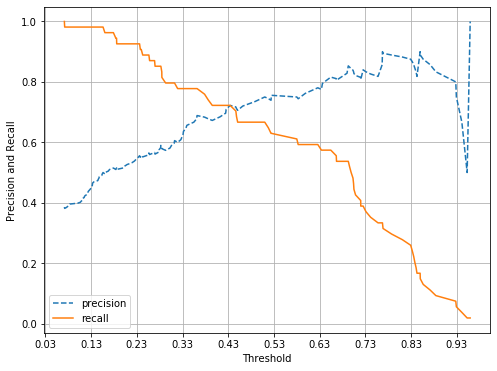

In [22]:
# get probabilities that we will predict positive 
pred_prob_c1 = logreg.predict_proba(X_test)[:,1] 

def precision_recall_curve_plot(Y_test,Prob): 
    precisions,recalls,thresholds = precision_recall_curve(Y_test,Prob) 
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]  
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle="--",label='precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recall') 
    start,end = plt.xlim() 
    plt.xticks(np.round(np.arange(start,end,0.1),2)) 
    plt.xlabel('Threshold') 
    plt.ylabel('Precision and Recall') 
    plt.legend() 
    plt.grid() 
    plt.show() 

precision_recall_curve_plot(Y_test,pred_prob_c1)

From the plot, we see that if we decrease the threshold (from 0.5) to 0.43, we will get a good balance of precision and recall. However, both these values seem to be less than 70%. Let us inspect the data again and see if we can improve these metrics. 

In [23]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Weird enough, there are many features with a minimum value of zero. This does not make sense for most of these features, because zero glucose level or zero blood pressure does not make much sense. If the number of such datapoints are small, we can treat them as anomaly and get rid of them.  

In [25]:
zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
total_count = diabetes_data['Glucose'].count() 
for feature in zero_features: 
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count() 
    print("There are {} zero values for {}, which is equivalent to {}%".format(zero_count,feature,100*zero_count/total_count))

There are 5 zero values for Glucose, which is equivalent to 0.6510416666666666%
There are 35 zero values for BloodPressure, which is equivalent to 4.557291666666667%
There are 227 zero values for SkinThickness, which is equivalent to 29.557291666666668%
There are 374 zero values for Insulin, which is equivalent to 48.697916666666664%
There are 11 zero values for BMI, which is equivalent to 1.4322916666666667%


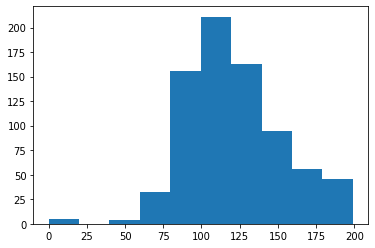

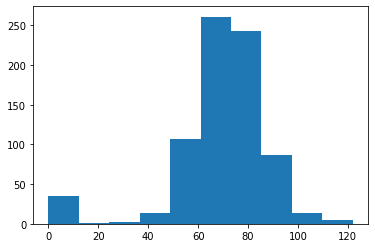

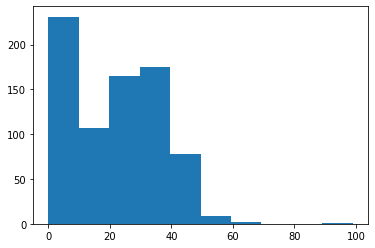

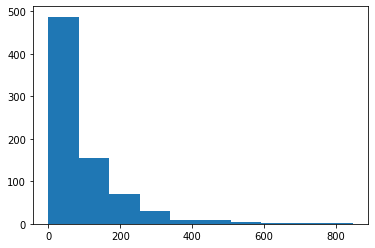

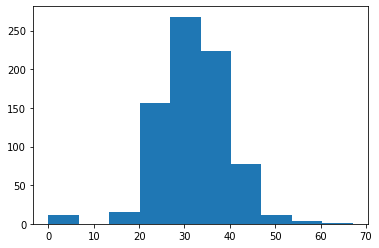

In [27]:
for feature in zero_features: 
    plt.hist(diabetes_data[feature],bins=10)
    plt.show()

There are too many values in the features SkinThickness and Insulin that have min values of zero. So we cannot simply discard these data points and treat them as anomalies. Let us instead replace the 0 with the mean of the feature. 

In [33]:
mean_zero_features = diabetes_data[zero_features].mean() 
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0,mean_zero_features) 

We then apply feature scaling to the X data. This should hopefully improve performance 

In [35]:
X = diabetes_data.iloc[:,:-1] 
Y = diabetes_data.iloc[:,-1] 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) # fit and transform 
X_train,X_test,Y_train,Y_test = train_test_split(X_scaled,Y,test_size=0.2,random_state=200,
                                                stratify=Y) 
logreg = LogisticRegression() 
logreg.fit(X_train,Y_train) 
prediction = logreg.predict(X_test) 
get_eval(Y_test,prediction)

Accuracy:0.8116883116883117, Precision:0.7906976744186046, Recall:0.6296296296296297, F1:0.7010309278350516, ROC-AUC:0.7698148148148148


We see a slight increase in accuracy from 80% to 81%. We still want to tune our recall score. Let us vary the threshold and try to find a sweet spot between recall and precision. 

In [39]:
thresholds = [0.3,0.32,0.34,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5] 
pred_prob = logreg.predict_proba(X_test) 

def get_eval_by_threshold(Y_test,pred_prob_c1,thresholds): 
    for t in thresholds: 
        binarizer = Binarizer(threshold = t).fit(pred_prob_c1) 
        predict = binarizer.transform(pred_prob_c1) 
        print("Threshold = ",t) 
        get_eval(Y_test,predict) 

get_eval_by_threshold(Y_test,pred_prob[:,1].reshape(-1,1),thresholds)

Threshold =  0.3
Accuracy:0.7597402597402597, Precision:0.6197183098591549, Recall:0.8148148148148148, F1:0.704, ROC-AUC:0.7724074074074074
Threshold =  0.32
Accuracy:0.7727272727272727, Precision:0.6376811594202898, Recall:0.8148148148148148, F1:0.7154471544715448, ROC-AUC:0.7824074074074074
Threshold =  0.34
Accuracy:0.7792207792207793, Precision:0.65625, Recall:0.7777777777777778, F1:0.711864406779661, ROC-AUC:0.778888888888889
Threshold =  0.36
Accuracy:0.7727272727272727, Precision:0.6610169491525424, Recall:0.7222222222222222, F1:0.6902654867256637, ROC-AUC:0.7611111111111112
Threshold =  0.38
Accuracy:0.7727272727272727, Precision:0.6666666666666666, Recall:0.7037037037037037, F1:0.6846846846846847, ROC-AUC:0.7568518518518519
Threshold =  0.4
Accuracy:0.7922077922077922, Precision:0.7037037037037037, Recall:0.7037037037037037, F1:0.7037037037037037, ROC-AUC:0.7718518518518518
Threshold =  0.42
Accuracy:0.7987012987012987, Precision:0.7169811320754716, Recall:0.7037037037037037, 

The best recall is achieved when we use a threshold of 0.3 and 0.32. However, we have a better F1 and ROC-AUC score when threshold is 0.32. The problem is that the precision is too low (0.637) so perhaps this is a bit too drastic of a measure. Threshold of 0.42 seems decent, with recall and precision both above 70% and F1 score being one of the highest (0.71). Also the prediction accuracy is better preserved than when we use a threshold of 0.32 (77.2% vs 79.8%). We will use a threshold of 0.42 to make predictions. 

In [40]:
binarizer = Binarizer(threshold=0.42) 
prediction = binarizer.fit_transform(pred_prob[:,1].reshape(-1,1))  
get_eval(Y_test,prediction)

Accuracy:0.7987012987012987, Precision:0.7169811320754716, Recall:0.7037037037037037, F1:0.7102803738317758, ROC-AUC:0.7768518518518519


We get the desired result. We need to set the threshold for the Binarizer because we cannot manually change the threshold for predict. 